- Vacuum processing는 데이터베이스의 지정된 테이블 또는 모든 테이블에 대해 다음 작업을 수행.

**데드 튜플 제거**

- 각 페이지에 대해 데드 튜플을 제거하고 라이브 튜플을 조각 모음함.
- 데드 튜플을 가리키는 인덱스 튜플을 제거.

**오래된 txid 동결**

- 필요한 경우 튜플의 이전 txid를 동결.
- 고정된 txid 관련 시스템 카탈로그(pg_database 및 pg_class)를 업데이트.
- 가능하면 막힌 부분의 불필요한 부분을 제거.

**기타**

- 처리된 테이블의 FSM 및 VM을 업데이트.
- 여러 통계(pg_stat_all_tables 등)를 업데이트.


**Code Pseudocode: Concurrent VACUUM**



```
(1)    FOR each table
(2)      Acquire a ShareUpdateExclusiveLock lock for the target table

         /* The first block */
(3)      Scan all pages to get all dead tuples, and freeze old tuples if necessary
(4)      Remove the index tuples that point to the respective dead tuples if exists

         /* The second block */
(5)      FOR each page of the table
(6)         Remove the dead tuples, and Reallocate the live tuples in the page
(7)         Update FSM and VM
         END FOR

         /* The third block */
(8)      Clean up indexes
(9)      Truncate the last page if possible
(10)     Update both the statistics and system catalogs of the target table
            Release the ShareUpdateExclusiveLock lock
      END FOR

      /* Post-processing */
(11)  Update statistics and system catalogs
(12)  Remove both unnecessary files and pages of the clog if possible
```

- (1) 지정된 테이블에서 각 테이블을 가져옴.
- (2) 테이블에 대해 ShareUpdateExclusiveLock 잠금을 획득. 이 잠금을 사용하면 다른 트랜잭션에서 읽을 수 있음.
- (3) 모든 페이지를 스캔하여 데드 튜플을 모두 얻고 필요한 경우 오래된 튜플을 동결.
- (4) 존재하는 경우 해당 데드 튜플을 가리키는 인덱스 튜플을 제거.
- (5) 표의 각 페이지에 대해 다음 작업(6)과 (7)을 수행.
- (6) 데드 튜플을 제거하고 페이지에서 라이브 튜플을 재할당.
- (7) 대상 테이블의 해당 FSM과 VM을 모두 업데이트.
- (8) index_vacuum_cleanup()@indexam.c 함수로 인덱스를 정리.
- (9) 마지막 페이지에 튜플이 없으면 마지막 페이지를 자름.
- (10) 대상 테이블의 Vacuum processing와 관련된 통계 및 시스템 카탈로그를 모두 업데이트.
- (11) Vacuum processing와 관련된 통계 및 시스템 카탈로그를 모두 업데이트.
- (12) 가능하면 불필요한 파일과 막힌 페이지를 모두 제거.

- 이 의사코드에는 각 테이블에 대한 루프와 사후 처리라는 두 개의 섹션이 있음.
- 내부 루프는 세 개의 블록으로 나눌 수 있음.
- 각 블록에는 개별 작업이 있음.
- 세 가지 블록과 사후 프로세스가 존재

**PARALLEL option**

- VACUUM 명령은 버전 13부터 PARALLEL 옵션을 지원.
- 이 옵션을 설정하고 여러 개의 인덱스가 생성된 경우 Vacuuming Index와 Cleaning Index Up 단계가 병렬로 처리됨.

- 이 기능은 VACUUM 명령에만 유효하며 autovacuum에서는 지원되지 않음.

# **First Block**

- 이 블록은 고정 처리를 수행하고 데드 튜플을 가리키는 인덱스 튜플을 제거.

- 먼저 PostgreSQL은 대상 테이블을 스캔하여 데드 튜플 목록을 작성하고 가능하면 오래된 튜플을 고정.
- 목록은 maintenance_work_mem 이라는 로컬 메모리에 저장 .

- 스캔 후 PostgreSQL은 데드 튜플 목록을 참조하여 인덱스 튜플을 제거.
- 이 프로세스를 내부적으로는 "cleanup stage"라고 . 비용이 많이 드는 프로세스이므로 PostgreSQL이 버전 11에서 개선되었음.

- 버전 10 이하에서는 cleanup stage가 항상 실행.
- 버전 11 이상에서는 대상 인덱스가 B-tree인 경우 cleanup stage의 실행 여부는 진공청소기_cleanup_index_scale_factor 구성 매개변수에 의해 결정 .


- maintenance_work_mem이 가득 차고 스캔이 완료되지 않은 경우 PostgreSQL은 다음 작업, 즉 (4)~(7)단계를 진행.
- 이후 (3)단계로 돌아가 나머지 스캔을 진행.

# **Second Block**

- 이 블록은 데드 튜플을 제거하고 페이지별로 FSM과 VM을 모두 업데이트

**Removing a dead tuple.**

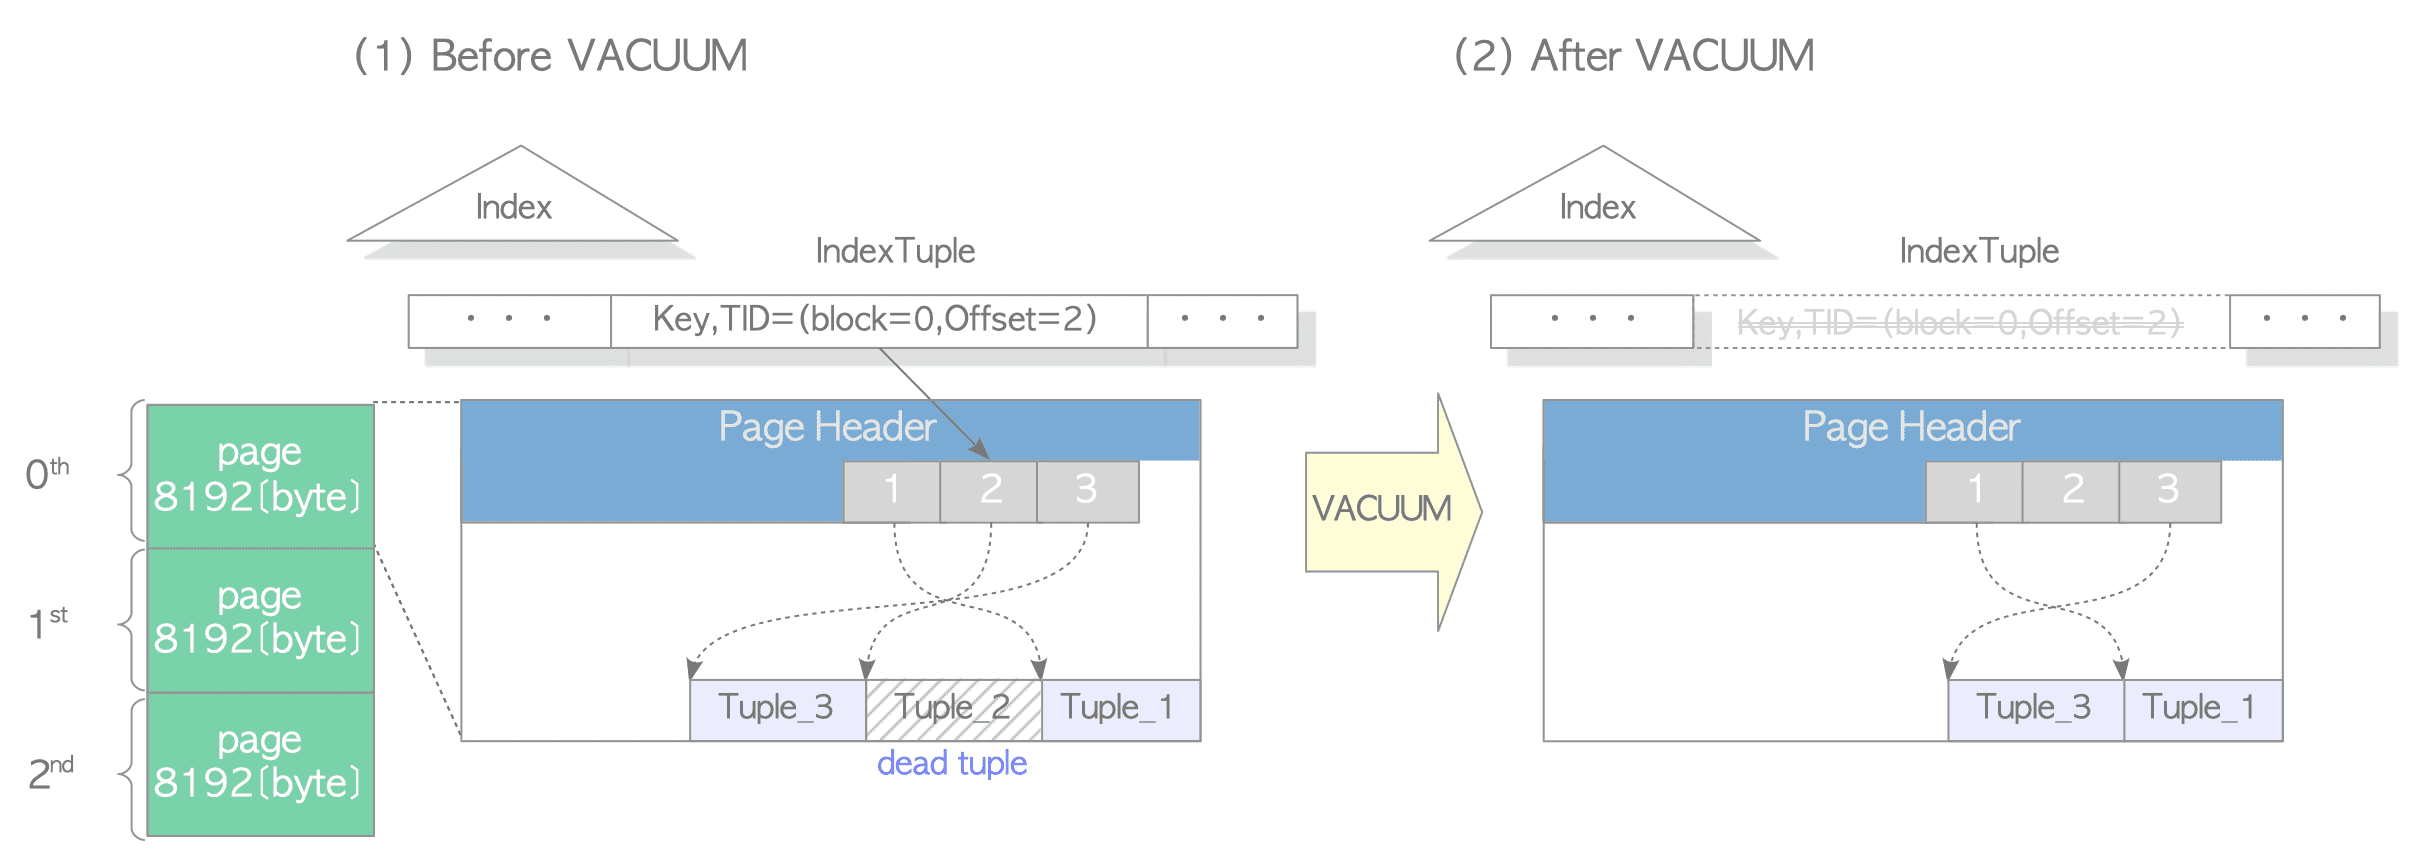

- 테이블에 세 개의 페이지가 있다고 가정.
- 0번째 페이지(즉, 첫 번째 페이지)에 초점을 맞춤.
- 이 페이지에는 세 개의 튜플이 있음.
- Tuple_2는 데드 튜플(그림 (1)).
- 이 경우 PostgreSQL은 Tuple 2를 제거하고 조각화를 복구하기 위해 나머지 튜플을 다시 정렬.
-  그런 다음 이 페이지의 FSM과 VM을 모두 업데이트(그림 (2)).
- PostgreSQL은 마지막 페이지까지 이 프로세스를 계속.

<br>

- 불필요한 라인 포인터는 제거되지 않음.
  - 앞으로는 재사용될 것.
  - 라인 포인터가 제거되면 연관된 인덱스의 모든 인덱스 튜플을 업데이트해야 하기 때문.

# **Third Block**

- 세 번째 블록은 인덱스 삭제 후 정리 작업을 수행하고, 각 대상 테이블에 대한 Vacuum 처리 관련 통계 및 시스템 카탈로그를 업데이트.

- 또한 마지막 페이지에 튜플이 없으면 테이블 파일에서 잘림

# **Post-processing**

- 진공 처리가 완료되면 PostgreSQL은 진공 처리와 관련된 모든 통계 및 시스템 카탈로그를 업데이트
- 또한 가능하면 막힘의 불필요한 부분을 제거

**Ring Buffer**

- 진공 처리 에서는 링 버퍼를 사용
- 따라서 처리된 페이지는 공유 버퍼에 캐시되지 않음